In [1]:
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

from nltk.tokenize import WordPunctTokenizer
import re
from bs4 import BeautifulSoup

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Display 100 characters max within a cell
pd.set_option('max_colwidth',200)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('text_emotion.csv')

## Data Understanding and Preprocessing

In [3]:
df.head(10)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will."
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!"
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?


It looks like there are lots of different characters, creative spelling and punctuation, misspellings, slang, new words or URLs. This needs to be fixed

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [5]:
pd.DataFrame([df.sentiment.value_counts(), df.sentiment.value_counts(normalize=True)]).T

,sentiment,sentiment
neutral,8638.0,0.215950
worry,8459.0,0.211475
happiness,5209.0,0.130225
sadness,5165.0,0.129125
love,3842.0,0.096050
surprise,2187.0,0.054675
fun,1776.0,0.044400
relief,1526.0,0.038150
hate,1323.0,0.033075
empty,827.0,0.020675


There are no empty rows 

Lets see the group of sentiments on a graph

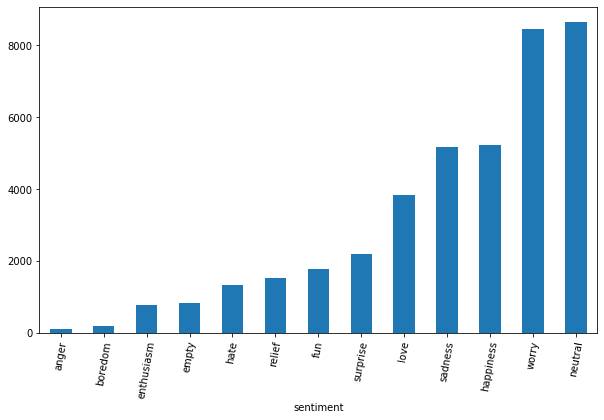

In [6]:
plt.subplots(figsize=(10,6))

df.groupby('sentiment')['content'].count().sort_values(ascending=True).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [7]:
df.describe(include='object')

,sentiment,author,content
count,40000,40000,40000
unique,13,33871,39827
top,neutral,MissxMarisa,I just received a mothers day card from my lovely daughter wishing my a happy mothers day http://tr.im/kWK9
freq,8638,23,14


In [8]:
df.isnull().sum()

tweet_id     0
sentiment    0
author       0
content      0
dtype: int64

No missing values

In [9]:
df.content.duplicated().sum()

173

It looks like there are duplicated tweets (which could be retweets maybe) that needs to be taken into consideration

In [10]:
df.content.value_counts()[df.content.value_counts()>1]

I just received a mothers day card from my lovely daughter wishing my a happy mothers day  http://tr.im/kWK9    14
FREE UNLIMITED RINGTONES!!! - http://tinyurl.com/freeringring - USA ONLY - Awesome 4 iphone                     13
Happy Mothers Day                                                                                               10
Happy Mother's Day!                                                                                             10
happy mother's day                                                                                               8
                                                                                                                ..
tummy hurts                                                                                                      2
happy star wars day                                                                                              2
about to go to sleep                                                            

In [11]:
df[df.content=='happy mothers day']

,tweet_id,sentiment,author,content
29348,1751177832,love,jadeeisabel,happy mothers day
36768,1753366853,love,janethglz,happy mothers day
36819,1753381594,happiness,bree_gee,happy mothers day
37340,1753468050,love,starbuckscup,happy mothers day
39131,1753773088,neutral,vwebling,happy mothers day


For the same tweet there are different sentiments in the sentiment column. I decided to drop these duplicates and different labels

In [12]:
df=df.drop_duplicates(subset='content')

In [13]:
df.content.duplicated().sum()

0

Now lets see the distribution of emotions in the data set

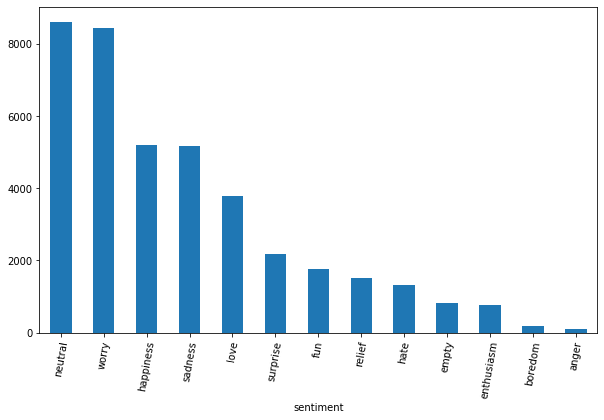

In [14]:
plt.subplots(figsize=(10,6))

df.groupby('sentiment')['content'].count().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [15]:
df.sentiment.value_counts()

neutral       8598
worry         8437
happiness     5184
sadness       5154
love          3785
surprise      2181
fun           1775
relief        1522
hate          1322
empty          822
enthusiasm     758
boredom        179
anger          110
Name: sentiment, dtype: int64

In [16]:
# spacy_tok = spacy.load('en')
# sample_review=df.content[8]
# sample_review

In [17]:
# parsed_review = spacy_tok(sample_review)
# parsed_review

It looks like there are some html characters within the text such as:‘&amp’,’&quot’,etc. For decoding html to general text, beautiful soup can be used

In [18]:
def tweet_cleaner(tweet):
    
#     # To lowercase (not good for VADER)
#     tweet = tweet.lower()
    
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    
    #Convert @username to "@user"
    tweet = re.sub('@[^\s]+','@user',tweet)
    
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ')
    
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF')
    
    # Remove hyperlinks ->>>> For now just replace with http
    tweet = re.sub(r'https?:\/\/.*\/\w*', 'http', tweet)
    
#     # Remove tickers such as USD ($)
#     tweet = re.sub(r'\$\w*', '', tweet)
    
#     # Remove hashtags (not good for VADER)
#     tweet = re.sub(r'#\w*', '', tweet)
    
#     # Remove Punctuation and split 's, 't, 've with a space for filter
#     tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    
#     # Remove words with 2 or fewer letters
#     tweet = re.sub(r'\b\w{1,2}\b', '', tweet)

    return tweet



# wordpunctok = WordPunctTokenizer()

# pat1 = r'@[A-Za-z0-9_]+'
# pat2 = r'https?://[^ ]+'

# combined_pat = r'|'.join((pat1, pat2))
# www_pat = r'www.[^ ]+'
# negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
#                 "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
#                 "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
#                 "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
#                 "mustn't":"must not"}
# neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

# def tweet_cleaner(text):
#     soup = BeautifulSoup(text, 'lxml')
#     souped = soup.get_text()
#     try:
#         quotRem = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
#     except:
#         quotRem = souped
#     stripped = re.sub(combined_pat, '', quotRem)
#     stripped = re.sub(www_pat, '', stripped)
#     lower_case = stripped.lower()
#     neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
#     letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)

#     words = [x for x  in wordpunctok.tokenize(letters_only) if len(x) > 1]
#     return (" ".join(words)).strip()

 

In [19]:

df['Cleaned'] = df.content.apply(tweet_cleaner)
df.head(10)

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,@user i know i was listenin to bad habit earlier and i started freakin at his part =[
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed with a headache ughhhh...waitin on your call...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.","@user We want to trade with someone who has Houston tickets, but no one will."
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,Re-pinging @user why didn't you go to prom? BC my bf didn't like my friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!","I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, he wants me 2! scandalous!"
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down,Hmmm. http is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you,@user Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,@user I'm sorry at least it's Friday?


### Removing the stopwords

In [20]:
stop = stopwords.words('english')
df['Cleaned'] = df['Cleaned'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df.head(10)

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,@user know listenin bad habit earlier started freakin part =[
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed headache ughhhh...waitin call...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants hang friends SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.","@user We want trade someone Houston tickets, one will."
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,Re-pinging @user go prom? BC bf like friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!","I sleep, im not! thinking old friend I want. he's married now. damn, wants 2! scandalous!"
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down,Hmmm. http
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you,@user Charlene love. I miss
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,@user I'm sorry least Friday?


### Let's apply a common words filter for removing most common words 

In [21]:
import pickle

MIN_NUMBER_OF_SR = 500
MIN_COM_WORDS = 0.01
MIN_UNCOM_WORDS = 0.01
UNCOM_WORDS = 0.01
dataframe = df
pivot_feature = 'sentiment'
text_feature = 'Cleaned'

def common_word_filter (dataframe, pivot_feature, text_feature):
    
    NUM_OF_SUB_TECH = len(dataframe[pivot_feature].value_counts()[dataframe[pivot_feature].value_counts() > MIN_NUMBER_OF_SR].index.tolist())
    
    list_common = []
    
    list_uncommon =[]
    
    list_least_common = []
    
    for sub_tech in dataframe[pivot_feature].value_counts()[dataframe[pivot_feature].value_counts() > MIN_NUMBER_OF_SR].index.tolist():
        
        cleaned_text = [str(txt) for text in dataframe[dataframe[pivot_feature] == sub_tech][text_feature] for txt in text.split(' ') if len(txt) > 2 and txt not in ' ']
        
        word_dist = nltk.FreqDist(cleaned_text)
        
        list_common.append([x[0] for x in word_dist.most_common(int(len(word_dist)*MIN_COM_WORDS))])
        
        list_uncommon.append([x[0] for x in word_dist.most_common(len(word_dist))[-int(len(word_dist)*MIN_UNCOM_WORDS):]])
        
        list_least_common.append([x[0] for x in word_dist.most_common(len(word_dist))[-int(len(word_dist)*UNCOM_WORDS):]])
    
    list_common_fl = [x for y in list_common for x in y]
    
    list_uncommon_fl = [x for y in list_uncommon for x in y]
    
    word_dist_com = nltk.FreqDist(list_common_fl)
    
    word_dist_ucom = nltk.FreqDist(list_uncommon_fl)
    
    list_final_com = [x[0] for x in word_dist_com.most_common(len(list_common_fl)) if x[1] > NUM_OF_SUB_TECH*0.75]
    
    list_final_ucom = [x[0] for x in word_dist_ucom.most_common(len(list_uncommon_fl)) if x[1] < NUM_OF_SUB_TECH*0.25]
    
    final_list = list(set(list_final_com + list_final_ucom + [y for x in list_least_common for y in x]))
    
    with open('common_word_list_for_filtering.pickle', 'wb') as handle:
    
        pickle.dump(final_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return final_list



In [22]:
final_list = common_word_filter(df, 'sentiment','Cleaned')

In [23]:
len(final_list)

1121

In [24]:
len(df.content)

39827

In [25]:
df['Cleaned'] = df['Cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (final_list)]))
df.head()

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,listenin bad habit earlier started freakin part =[
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed headache ughhhh...waitin call...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants hang friends SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.","We trade someone Houston tickets, will."


### We can apply our first models to cleaned content

In [26]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df['Cleaned'],
                                                    df['sentiment'],
                                                    test_size=.25, random_state=53)

### Count vectorizing

In [27]:
count_vect2 = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.999)
count_vect_train2 = count_vect2.fit_transform(X_train2)
count_vect_train2 = count_vect_train2.toarray()
count_vect_test2 = count_vect2.transform(X_test2)
count_vect_test2 = count_vect_test2.toarray()

### Logistic Regression

In [28]:
logreg_CV2 = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight='balanced',
                              C=1.0,n_jobs=-1, random_state=5)
logreg_CV2.fit(count_vect_train2, y_train2)
y_pred_lr_CV2 = logreg_CV2.predict(count_vect_test2)
print('Accuracy :', metrics.accuracy_score(y_test2, y_pred_lr_CV2))

Accuracy : 0.22165310836597368


Because of the feuture distribution of the sample, we were expecting a low accuracy in our model. In order to balance the distribution, we can update the categorization of the emotions.

We have 13 emotions and we can categorize them in 3 sentiment categories: positive, neutral and negative

anger, boredom, hate, worry, sadness: Negative

happiness, fun, love, surprise, enthusiasm, relief: Positive

empty, neutral : Neutral

In [29]:
dfnew=df.copy()

In [30]:
dfnew.sentiment.replace(['anger','boredom','hate','worry','sadness','happiness','fun','love','surprise','enthusiasm','relief','empty','neutral'],
                    ['negative','negative','negative','negative','negative','positive','positive','positive','positive','positive','positive','neutral','neutral'],
                       inplace=True)

In [31]:
dfnew.head(20)

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,listenin bad habit earlier started freakin part =[
1,1956967666,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed headache ughhhh...waitin call...
2,1956967696,negative,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...
3,1956967789,positive,czareaquino,wants to hang out with friends SOON!,wants hang friends SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.","We trade someone Houston tickets, will."
5,1956968477,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,Re-pinging go prom? BC bf friends
6,1956968487,negative,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!","I sleep, im not! thinking old friend I want. he's married now. damn, wants 2! scandalous!"
7,1956968636,negative,mcsleazy,Hmmm. http://www.djhero.com/ is down,Hmmm.
8,1956969035,negative,nic0lepaula,@charviray Charlene my love. I miss you,Charlene love. I miss
9,1956969172,negative,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,sorry least Friday?


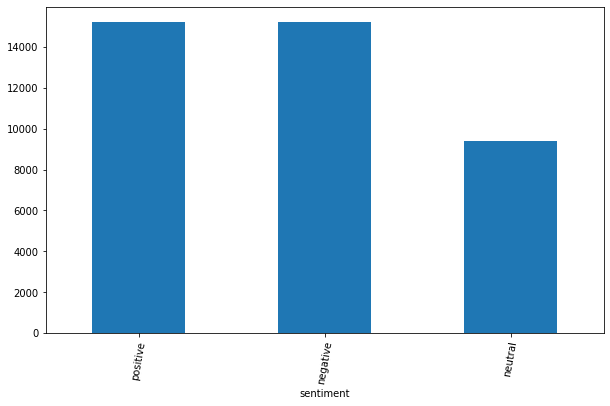

In [32]:
plt.subplots(figsize=(10,6))

dfnew.groupby('sentiment')['content'].count().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

### Lets add the new cleaned data set to our data set

In [33]:
dfadd = pd.read_csv('additionalclean.csv')

In [34]:
dfbig = pd.concat([dfnew, dfadd], ignore_index=True, sort =False)
dfbig.shape

(54254, 6)

In [35]:
dfbig.head(-10)

,tweet_id,sentiment,author,content,Cleaned,Unnamed: 0
0,1.956967e+09,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,listenin bad habit earlier started freakin part =[,NaN
1,1.956968e+09,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed headache ughhhh...waitin call...,NaN
2,1.956968e+09,negative,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,NaN
3,1.956968e+09,positive,czareaquino,wants to hang out with friends SOON!,wants hang friends SOON!,NaN
4,1.956968e+09,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.","We trade someone Houston tickets, will.",NaN
...,...,...,...,...,...,...
54239,5.695900e+17,positive,681679784,@AmericanAir Flight 236 was great. Fantastic cabin crew. A+ landing. #thankyou #JFK http://t.co/dRW08djHAI,@user Flight 236 great. Fantastic cabin crew. A+ landing. #thankyou #JFK http,14625.0
54240,5.695890e+17,negative,681679785,@AmericanAir Flight 953 NYC-Buenos Aires has been delay since yesterday at 10PM. Is going to take off at 3.30PM now? Give us answers!,@user Flight 953 NYC-Buenos Aires delay since yesterday 10PM. Is going take 3.30PM now? Give us answers!,14626.0
54241,5.695890e+17,negative,681679786,"@AmericanAir Flight Cancelled Flightled, can't go home until tomorrow. I could use dinner and a play, @AmericanAir! It's my first time in NYC.","@user Flight Cancelled Flightled, can't go home tomorrow. I could use dinner play, @user It's first time NYC.",14627.0
54242,5.695890e+17,positive,681679787,"Thank you. ÛÏ@AmericanAir: @jlhalldc Customer Relations will review your concerns and contact you back directly, John.Û","Thank you. ÛÏ@user @user Customer Relations review concerns contact back directly, John.Û",14628.0


In [36]:
dfbig = dfbig.drop(['Unnamed: 0'], axis=1)
dfnew=dfbig
dfnew.head()

,tweet_id,sentiment,author,content,Cleaned
0,1.956967e+09,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,listenin bad habit earlier started freakin part =[
1,1.956968e+09,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed headache ughhhh...waitin call...
2,1.956968e+09,negative,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...
3,1.956968e+09,positive,czareaquino,wants to hang out with friends SOON!,wants hang friends SOON!
4,1.956968e+09,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.","We trade someone Houston tickets, will."


## Train-Test Split

In [37]:

X_train, X_test, y_train, y_test = train_test_split(dfnew['Cleaned'],
                                                    dfnew['sentiment'],
                                                    test_size=.25, random_state=53)

## Count Vectirizing

In [38]:
count_vect = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.999)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [39]:
vocab = count_vect.get_feature_names()

In [40]:
pd.DataFrame(count_vect_train, columns=vocab).head(10)

,000,10,100,11,12,14,15,16,17,18,...,yet,yo,you,young,your,youtube,yr,yummy,yup,ûï
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Logistic Regression

In [41]:

logreg_CV = LogisticRegression(random_state=0)
logreg_CV.fit(count_vect_train, y_train)
y_pred_lr_CV = logreg_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_CV))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy : 0.620023591860808


##  Linear SVC

In [42]:

Lsvc = LinearSVC()

Lsvc.fit(count_vect_train, y_train)

pred= Lsvc.predict(count_vect_test)

metrics.accuracy_score(y_test, pred)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6197286936007077

## Naive Bayes

In [43]:

from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()

nb_classifier.fit(count_vect_train, y_train)

pred = nb_classifier.predict(count_vect_test)

metrics.accuracy_score(y_test, pred)

0.5793276319669713

## Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf_CV = RandomForestClassifier(n_estimators = 200, random_state=5)
rf_CV.fit(count_vect_train, y_train)
y_pred_rf_CV = rf_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_rf_CV))

Accuracy : 0.5850781480389265


## Tf-idf Vectorization¶

In [45]:
tfidf_vect = TfidfVectorizer(min_df=1, max_df=1.0, use_idf=True)
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
vocab = tfidf_vect.get_feature_names()
pd.DataFrame(np.round(tfidf_vect_train, 2), columns=vocab).head(10)

print('Longest word:', max(tfidf_vect.vocabulary_, key=len))

Longest word: sleeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeep


## Logreg after Tf-idf

In [46]:
logreg_TV = LogisticRegression(class_weight='balanced', random_state=5)
logreg_TV.fit(tfidf_vect_train, y_train)
y_pred_lr_TV = logreg_TV.predict(tfidf_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_TV))
print (classification_report(y_test, y_pred_lr_TV))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy : 0.6245945148923622
              precision    recall  f1-score   support

    negative       0.71      0.71      0.71      6137
     neutral       0.44      0.44      0.44      3096
    positive       0.63      0.64      0.63      4331

    accuracy                           0.62     13564
   macro avg       0.59      0.60      0.60     13564
weighted avg       0.62      0.62      0.62     13564



## Cross Validation

In [47]:
from sklearn.model_selection import cross_val_score
cvresult = cross_val_score(logreg_CV, count_vect_train, y_train,cv=5)

print(cvresult)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

[0.61371176 0.61292701 0.61685918 0.61132957 0.6246774 ]


## Lets try NLTK Vader for sentiment comparison

In [48]:

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [49]:
def sentiment_analyzer_scores(sentence):
    '''
    Evaluates polarity scores of a given sentence and prints the result.
    '''
    score = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

analyzer = SentimentIntensityAnalyzer()

In [50]:

sentiments = []
compounds = []
sid = SentimentIntensityAnalyzer()
for i in dfnew.content:
    sentiment = sid.polarity_scores(i)
    if sentiment['compound']< -0.05:
        sentiments.append('negative')    
    elif sentiment['compound']> 0.05:
        sentiments.append('positive')
    else:
        sentiments.append('neutral')
    compounds.append(sentiment)
    
dfnew['vader'] = pd.DataFrame(sentiments)
dfnew['compound'] = compounds


In [51]:
dfnew.head(30)

,tweet_id,sentiment,author,content,Cleaned,vader,compound
0,1.956967e+09,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,listenin bad habit earlier started freakin part =[,negative,"{'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.5423}"
1,1.956968e+09,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed headache ughhhh...waitin call...,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2,1.956968e+09,negative,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,negative,"{'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}"
3,1.956968e+09,positive,czareaquino,wants to hang out with friends SOON!,wants hang friends SOON!,positive,"{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}"
4,1.956968e+09,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.","We trade someone Houston tickets, will.",negative,"{'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}"
5,1.956968e+09,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,Re-pinging go prom? BC bf friends,negative,"{'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}"
6,1.956968e+09,negative,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!","I sleep, im not! thinking old friend I want. he's married now. damn, wants 2! scandalous!",negative,"{'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}"
7,1.956969e+09,negative,mcsleazy,Hmmm. http://www.djhero.com/ is down,Hmmm.,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
8,1.956969e+09,negative,nic0lepaula,@charviray Charlene my love. I miss you,Charlene love. I miss,positive,"{'neg': 0.163, 'neu': 0.408, 'pos': 0.429, 'compound': 0.5574}"
9,1.956969e+09,negative,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,sorry least Friday?,negative,"{'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'compound': -0.0772}"


In [52]:
dfnew=dfnew[['tweet_id','author','content','Cleaned','sentiment','vader','compound']]
dfnew.head(30)

,tweet_id,author,content,Cleaned,sentiment,vader,compound
0,1.956967e+09,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,listenin bad habit earlier started freakin part =[,neutral,negative,"{'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.5423}"
1,1.956968e+09,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed headache ughhhh...waitin call...,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2,1.956968e+09,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,negative,negative,"{'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}"
3,1.956968e+09,czareaquino,wants to hang out with friends SOON!,wants hang friends SOON!,positive,positive,"{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}"
4,1.956968e+09,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.","We trade someone Houston tickets, will.",neutral,negative,"{'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}"
5,1.956968e+09,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,Re-pinging go prom? BC bf friends,negative,negative,"{'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}"
6,1.956968e+09,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!","I sleep, im not! thinking old friend I want. he's married now. damn, wants 2! scandalous!",negative,negative,"{'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}"
7,1.956969e+09,mcsleazy,Hmmm. http://www.djhero.com/ is down,Hmmm.,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
8,1.956969e+09,nic0lepaula,@charviray Charlene my love. I miss you,Charlene love. I miss,negative,positive,"{'neg': 0.163, 'neu': 0.408, 'pos': 0.429, 'compound': 0.5574}"
9,1.956969e+09,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,sorry least Friday?,negative,negative,"{'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'compound': -0.0772}"


In [53]:
for i in dfnew.index[0:10]:
    print(i)
    sentiment_analyzer_scores(dfnew.content[i])

0
@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[ {'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.5423}
1
Layin n bed with a headache  ughhhh...waitin on your call... {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
2
Funeral ceremony...gloomy friday...----- {'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}
3
wants to hang out with friends SOON!---- {'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}
4
@dannycastillo We want to trade with someone who has Houston tickets, but no one will. {'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}
5
Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends {'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}
6
I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous! {'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}
7
Hmmm. http://www.dj

Let's compare the sentiments in our data and the 'Vader' results

In [54]:
(dfnew.sentiment==dfnew.vader).mean()

0.5424116194197662

In [55]:
dfnew[dfnew.sentiment!=dfnew.vader].sample(10)

,tweet_id,author,content,Cleaned,sentiment,vader,compound
19403,1.966265e+09,monkeyjunkie,"Alex slammed her head into the edge of the table about 30 min ago. She's going to have a nice, blue bruise.","Alex slammed head edge table 30 min ago. She's nice, blue bruise.",negative,positive,"{'neg': 0.0, 'neu': 0.877, 'pos': 0.123, 'compound': 0.4215}"
25997,1.695280e+09,NotAPretender,@urbanfly well you are a tricky one so I would say 6.5,well tricky I say 6.5,neutral,positive,"{'neg': 0.137, 'neu': 0.684, 'pos': 0.179, 'compound': 0.128}"
35625,1.753176e+09,Soultwin,"And they are so censoring over at nin.com, nobody can really speculate about these things are disagree with anything","And censoring nin.com, nobody speculate things disagree anything",positive,negative,"{'neg': 0.126, 'neu': 0.874, 'pos': 0.0, 'compound': -0.3818}"
47288,5.695710e+17,681458078,@JetBlue I don't believe so. That's not what the team has told us.,@user I believe so. That's team told us.,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
9961,1.962776e+09,katelinzentz,"Visiting the grandparents in Manhattan, and dropping off my sister for the week! I wish I had an excuse to be so tired today..","Visiting grandparents Manhattan, dropping sister week! I wish I excuse tired today..",positive,negative,"{'neg': 0.138, 'neu': 0.703, 'pos': 0.159, 'compound': -0.2578}"
6300,1.961221e+09,BrookieeeW,Wishes she had a pool,Wishes pool,negative,positive,"{'neg': 0.0, 'neu': 0.652, 'pos': 0.348, 'compound': 0.1531}"
6631,1.961378e+09,Da7o0om,@AsMooNy ta3ally ma3ahaa w e83idy sa5neeha ly 6ool el 6ireee8 astaaahil wla :-p &lt;&lt;&lt; kfff looool wallah thx bard w 7ar ahm shy 8ahwaaa =|,ta3ally ma3ahaa w e83idy sa5neeha ly 6ool el 6ireee8 astaaahil wla :-p kfff looool wallah thx bard w 7ar ahm shy 8ahwaaa =|,negative,positive,"{'neg': 0.125, 'neu': 0.592, 'pos': 0.283, 'compound': 0.7003}"
6402,1.961252e+09,cherrystphoto,workout stunk...no headphones.,workout stunk...no headphones.,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
40191,5.684730e+17,681448854,"@VirginAmerica Done, but I need the receipt ASAP. Could you please help? #150219-000114","@user Done, I need receipt ASAP. Could please help? #150219-000114",neutral,positive,"{'neg': 0.0, 'neu': 0.606, 'pos': 0.394, 'compound': 0.7579}"
7289,1.961614e+09,cassierenee33,Wishing the rain would stay away for a while so that I can go to the pool,Wishing rain stay away I go pool,negative,positive,"{'neg': 0.0, 'neu': 0.881, 'pos': 0.119, 'compound': 0.2263}"


It looks like, our dataset's classification is better than vader's classification. On the other hand, it is obvious that (because twitter texts are very short) our common words cleaner cleaned more than needed. 

## Applying Deep Learning

In [56]:

import keras
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=2500,split=' ')
tokenizer.fit_on_texts(dfnew.Cleaned)


Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [57]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(dfnew.Cleaned)
X = pad_sequences(X)
print(X)

[[   0    0    0 ...  654 1817  558]
 [   0    0    0 ...  128  563   70]
 [   0    0    0 ... 1689 2294  231]
 ...
 [   0    0    0 ...  641  925  524]
 [   0    0    0 ... 1792    1  213]
 [   0    0    0 ...   60   73    3]]


In [58]:
Y = []
for val in dfnew.sentiment:
    if(val == 'positive'):
        Y.append([1,0,0])
    elif (val=='neutral'):
        Y.append([0,1,0])
    else:
        Y.append([0,0,1])
Y = np.array(Y)
print(Y)

[[0 1 0]
 [0 0 1]
 [0 0 1]
 ...
 [0 1 0]
 [0 0 1]
 [0 1 0]]


In [59]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X,Y,test_size=0.25)

In [60]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM

model = Sequential()
model.add(Embedding(2500,128,input_length=X.shape[1],dropout=0.2))
model.add(LSTM(300, dropout_U=0.2,dropout_W=0.2))
model.add(Dense(3,activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])




Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(300, dropout=0.2, recurrent_dropout=0.2)`
  


In [ ]:
model.fit(X_tr ,y_tr, epochs=5,verbose=2,batch_size=32)

Epoch 1/5


In [62]:
print(model.evaluate(X_ts,y_ts)[1])

13564/13564 [==============================] - 71s 5ms/step
0.6252580360303196
